In [1]:
import sys
print(sys.executable)

/media/HHD_2TB/baurai/aditya_vm/bin/python3.6


In [35]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import  confusion_matrix, f1_score, precision_score, recall_score, classification_report
import tensorflow as tf

print("Python version used = ", sys.version)
print("Numpy version = ", np.__version__)
print("Tensorflow version = ", tf.__version__)

Python version used =  3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
Numpy version =  1.18.5
Tensorflow version =  2.3.1


In [3]:
config = {
    "IMAGE_SIZE" : (512, 512),
    "BATCH_SIZE" : 32,
    "EPOCHS" : 32
}

DATASET_PATH = "/media/HHD2/NIH/tflow_obj_detection/images/"

In [4]:
metadata = pd.DataFrame(pd.read_csv("tfrec_v2/metadata_bin_clf_tfrec.csv"))

print("Shape = ", metadata.shape)

Shape =  (79988, 3)


In [5]:
metadata.head()

,image_name,label,subset
0,00012907_003.png,0,training
1,00014264_002.png,0,training
2,00001650_007.png,0,training
3,00013894_000_0.png,1,training
4,00013894_000_1.png,1,training


In [6]:
val = metadata[metadata["subset"] == "validation"]
STEPS_VAL = int(np.ceil(val.shape[0] /config["BATCH_SIZE"]))


print("Validation data shape = ", val.shape)
print("Validation steps = ", STEPS_VAL)
val.head()

Validation data shape =  (10004, 3)
Validation steps =  313


,image_name,label,subset
59980,00005564_014.png,0,validation
59981,00000488_002.png,0,validation
59982,00014792_002.png,1,validation
59983,00014274_008.png,1,validation
59984,00002874_000.png,0,validation


In [7]:
healthy_cases = len(val[val["label"] == 0])
nodular_cases = len(val[val["label"] == 1])

print("Healthy cases in validation set = ", healthy_cases)
print("Nodular cases in validation set = ", nodular_cases)

Healthy cases in validation set =  9054
Nodular cases in validation set =  950


In [8]:
test = metadata[metadata["subset"] == "testing"]

print("Testing data shape = ", test.shape)
test.head()

Testing data shape =  (10004, 3)


,image_name,label,subset
69984,00008490_001.png,0,testing
69985,00014877_020.png,0,testing
69986,00025686_003.png,0,testing
69987,00007060_016.png,0,testing
69988,00012364_015.png,0,testing


In [9]:
healthy_cases = len(test[test["label"] == 0])
nodular_cases = len(test[test["label"] == 1])

print("Healthy cases in testing set = ", healthy_cases)
print("Nodular cases in testing set = ", nodular_cases)

Healthy cases in testing set =  9055
Nodular cases in testing set =  949


In [10]:
val_images_path = [] 
val_images_label = []

for (val_image, val_label) in zip(val.image_name, val.label) : 
    image_path = DATASET_PATH + val_image
    val_images_path.append(image_path)
    val_images_label.append(str(val_label))

        
test_images_path = []
test_images_label = []
for (test_image, test_label) in zip(test.image_name, test.label) : 
    image_path = DATASET_PATH + test_image
    test_images_path.append(image_path)
    test_images_label.append(str(test_label))

In [11]:
data_tuples = list(zip(val_images_path, val_images_label))
dataframe_val = pd.DataFrame(data_tuples, columns = ["val_image_path", "label"])

print("Shape = ", dataframe_val.shape)
dataframe_val.head()

Shape =  (10004, 2)


,val_image_path,label
0,/media/HHD2/NIH/tflow_obj_detection/images/000...,0
1,/media/HHD2/NIH/tflow_obj_detection/images/000...,0
2,/media/HHD2/NIH/tflow_obj_detection/images/000...,1
3,/media/HHD2/NIH/tflow_obj_detection/images/000...,1
4,/media/HHD2/NIH/tflow_obj_detection/images/000...,0


In [12]:
data_tuples = list(zip(test_images_path, test_images_label))
dataframe_test = pd.DataFrame(data_tuples, columns = ["test_image_path", "label"])

print("Shape = ", dataframe_test.shape)
dataframe_test.head()

Shape =  (10004, 2)


,test_image_path,label
0,/media/HHD2/NIH/tflow_obj_detection/images/000...,0
1,/media/HHD2/NIH/tflow_obj_detection/images/000...,0
2,/media/HHD2/NIH/tflow_obj_detection/images/000...,0
3,/media/HHD2/NIH/tflow_obj_detection/images/000...,0
4,/media/HHD2/NIH/tflow_obj_detection/images/000...,0


In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0, preprocessing_function = None)
val = datagen.flow_from_dataframe(dataframe = dataframe_val, x_col = "val_image_path", y_col = "label",
                                  batch_size = config["BATCH_SIZE"], class_mode = "binary",
                                  target_size = config["IMAGE_SIZE"], shuffle = False)
test = datagen.flow_from_dataframe(dataframe = dataframe_test, x_col = "test_image_path", y_col = "label",
                                  batch_size = config["BATCH_SIZE"], class_mode = "binary",
                                  target_size = config["IMAGE_SIZE"], shuffle = False)

Found 10004 validated image filenames belonging to 2 classes.
Found 10004 validated image filenames belonging to 2 classes.


In [14]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.config.optimizer.set_experimental_options({"auto_mixed_precision" : True})
print("Mixed precision available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision available


In [15]:
with tf.device("/device:GPU:0") : 
    model = tf.keras.models.load_model("saved_models/bin_clf/resnet50v2_model")
    model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
batch_normalization_8 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               66048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [16]:
with tf.device("/device:GPU:0") :
    y_pred = model.predict_generator(val, STEPS_VAL, verbose = True)

Instructions for updating:
Please use Model.predict, which supports generators.
313/313 [==============================] - 190s 608ms/step


In [20]:
y_true = val.classes
type(y_true)

list

In [21]:
predicted_labels = []
for prob in y_pred : 
    if prob >= 0.5 : 
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

[[8706  348]
 [ 807  143]]


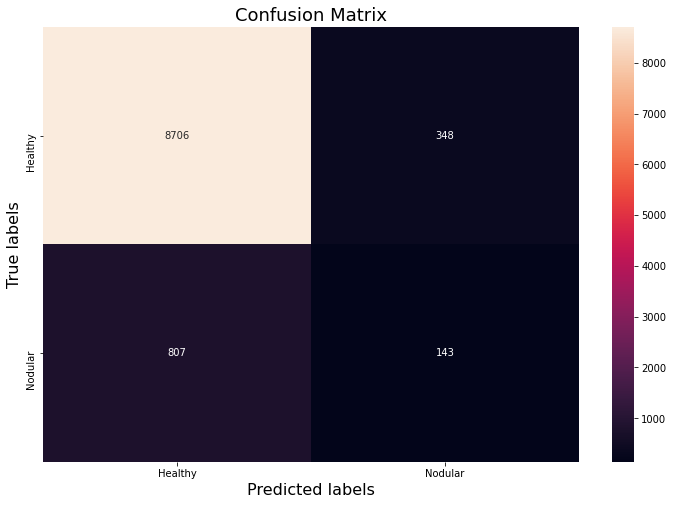

In [28]:
cm = confusion_matrix(y_true, predicted_labels)
print(cm)

plt.figure(figsize = (12, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = "d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 16)
ax.set_ylabel('True labels', fontsize = 16) 
ax.set_title('Confusion Matrix', fontsize = 18) 
ax.xaxis.set_ticklabels(['Healthy', 'Nodular'])
ax.yaxis.set_ticklabels(['Healthy', 'Nodular']);

In [33]:
f1 = f1_score(y_true, predicted_labels, average = "binary")
precision = precision_score(y_true, predicted_labels, average = "binary")
recall = recall_score(y_true, predicted_labels, average = "binary")
print("f1 score = ", f1)
print("precision = ", precision)
print("Recall = ", recall)

f1 score =  0.1984732824427481
precision =  0.29124236252545826


In [38]:
print(classification_report(y_true, predicted_labels, labels = [0, 1], target_names = ["Healthy", "Nodular"]))

              precision    recall  f1-score   support

     Healthy       0.92      0.96      0.94      9054
     Nodular       0.29      0.15      0.20       950

    accuracy                           0.88     10004
   macro avg       0.60      0.56      0.57     10004
weighted avg       0.86      0.88      0.87     10004

